In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import graph_tool.all as gt
from datetime import datetime

In [2]:
edge_df = pd.read_csv('dataset/fruitfly/condensed-edges.csv')
neuron_df = pd.read_csv('dataset/fruitfly/condensed-neurons.csv')

In [3]:
motif3_f = open('dataset/fruitfly/motif-size-003-certificates.txt', 'r')
line = motif3_f.readline()
motif_counts = []
motif_strs = []
while line:
    if ': ' in line:
        motif_strs.append(line.split(': ')[0])
        motif_counts.append(int(line.split(': ')[1].strip()))
    line = motif3_f.readline()

In [5]:
nx2gt = {0:1, 1:2, 2:0, 3:4, 4:5, 5:9, 6:3, 7:7, 8:11, 9:8, 10:10, 11:12, 12:6}
d = {}
for i in range(len(motif_strs)):
    d[motif_strs[i]] = nx2gt[i]
print(d)

{'000000000000000000000000000000800000000000000080': 1, '000000000000000000000000000000800000000000000040': 2, '0000000000000000000000000000000000000000000000c0': 0, '0000000000000000000000000000002000000000000000c0': 4, '000000000000004000000000000000800000000000000080': 5, '0000000000000020000000000000002000000000000000c0': 9, '0000000000000000000000000000008000000000000000c0': 3, '000000000000000000000000000000a000000000000000c0': 7, '000000000000004000000000000000a000000000000000c0': 11, '0000000000000040000000000000008000000000000000c0': 8, '0000000000000040000000000000002000000000000000c0': 10, '000000000000006000000000000000a000000000000000c0': 12, '000000000000004000000000000000200000000000000080': 6}


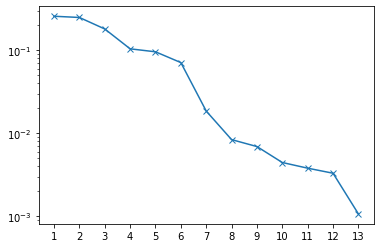

In [4]:
plt.plot([str(i) for i in range(1,14)], [i/sum(motif_counts) for i in motif_counts],marker='x',label='original')
plt.yscale('log')

In [ ]:
# certificate = '000000000000000000000000000000800000000000000080'
k = 3
i = 0
for certificate in motif_strs:
    nx_graph = nx.DiGraph()
    edge_colored = False
    # coloring = certificate[-16 * k * k:]
    # certificate = certificate[:-16 * k * k]

    # convert the vertex bytes (in hex) to base 10 integer
    # edge_colors = [int(coloring[16 * iv:16 * (iv + 1)], 16) for iv in range(k * k)]
    bytes_per_vertex = len(certificate) // k // 2

    # iterate over every vertex and extract the corresponding adjacency matrix
    for vertex in range(k):
        # multiple by two since we are using two characters in the string per byte (wrriten in hexademical)
        certificate_bytes = certificate[vertex * bytes_per_vertex * 2:(vertex + 1) * bytes_per_vertex * 2]

        for byte_offset, iv in enumerate(range(0, len(certificate_bytes), 2)):
            # get the byte as an integer (using hexadecimal currently)
            byte = int(certificate_bytes[iv:iv+2], 16)
            assert (byte < 256)

            # 8 bits per byte (little endian)
            for bit_offset in range(8):
                bit = byte & (2 ** 7)
                byte = byte << 1

                # if this bit is 1, there is an edge from vertex to this location
                if bit:
                    # determine the neighbor by the byte and bit offset
                    neighbor_vertex = 8 * (bytes_per_vertex - byte_offset - 1) + bit_offset
                    # if there is no edge coloring, we can just add a simple edge
                    if not edge_colored:
                        nx_graph.add_edge(vertex, neighbor_vertex)
                    else:
                        # create a coloringn for edges
                        color = edge_colors[vertex * k + neighbor_vertex]

                        # currently colors are based on edge strength (0 = moderate, 1 = strong)
                        nx_graph.add_edge(vertex, neighbor_vertex, penwidth = 2 * color + 1)
    nx.draw(nx_graph)
    plt.show()
    print('graph', i)
    i += 1

# erdos ranyi graph, it cannot even generate all 13 types of size-3 motifs. Motif distribution omit.

In [3]:
rand_G = nx.erdos_renyi_graph(21739, 841720.0/(21739*21738), directed=True)


# configuration model

In [9]:
import random

G = nx.from_pandas_edgelist(edge_df, 'Pre Synaptic Neuron ID', 'Post Synaptic Neuron ID', create_using=nx.DiGraph)

indeg = [i[1] for i in G.in_degree]
outdeg = [i[1] for i in G.out_degree]
lamd = sum([i*j for i in indeg for j in outdeg])/len(G.edges)

rand_G = gt.Graph()
rand_G.add_vertex((len(indeg)))
for i in range(len(indeg)):
    for j in range(len(outdeg)):
        if i!=j and random.uniform(0, 1)<indeg[i]*outdeg[j]/lamd:
            rand_G.add_edge(i,j)
rand_motif3 = gt.motifs(rand_G, 3)

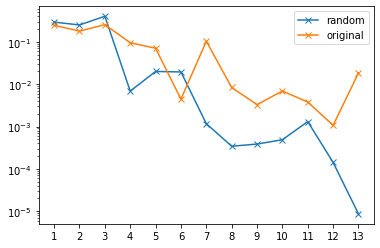

In [10]:
nx2gt = {0:1, 1:2, 2:0, 3:4, 4:5, 5:9, 6:3, 7:7, 8:11, 9:8, 10:10, 11:12, 12:6}
plt.plot([str(i) for i in range(1,14)], [i/sum(rand_motif3[1]) for i in rand_motif3[1]],marker='x',label='random')
plt.plot([str(i) for i in range(1,14)], [motif_counts[nx2gt[i]]/sum(motif_counts) for i in range(13)],marker='x',label='original')
plt.yscale('log')
plt.legend()